## exercise 1

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [23]:
#read_data
df = pd.read_csv('titanic_modified_dataset.csv', index_col='PassengerId')
x = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].to_numpy().reshape(-1,1)

In [24]:
# chia dữ liệu thành 3 phần (training, validation, test)
val_size = 0.2
test_size = 0.125
random_state = 42
is_shuffle = True
x_train, x_val, y_train, y_val = train_test_split(x, y,  test_size= val_size,
                                                  random_state=random_state, shuffle=is_shuffle )
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size,  
                                                    random_state=random_state, shuffle=is_shuffle)



In [25]:
## chuẩn hóa dư liệu
scaler = StandardScaler()
x_train_processed = scaler.fit_transform(x_train)
x_val_processed = scaler.transform(x_val)
x_test_processed = scaler.transform(x_test)

In [26]:
def add_bias_to_x(data):
    interpret = np.ones((data.shape[0],1))
    x_b =np.concatenate((interpret, data), axis = 1)
    return x_b

In [27]:
x_b_train_processed = add_bias_to_x(x_train_processed)
x_b_val_processed = add_bias_to_x(x_val_processed)
x_b_test_processed = add_bias_to_x(x_test_processed)

In [28]:
def sigmoid_funtion(z):
    result = 1/(1+np.exp(-z))
    return result

def predict(x_data, theta):
    z = np.dot(x_data, theta)
    y_hat = sigmoid_funtion(z)
    return z, y_hat

def loss_funtion(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1-(1e-7))
    result = (-y*(np.log(y_hat)) - (1-y)*(np.log(1-y_hat))).mean()
    return result

def gradient(x, y_hat, y):
    m = len(y)
    grad = np.dot(x.T, (y_hat - y))/m
    return grad

def update_theta(old_theta, grad, lr = 0.01):
    result = old_theta - lr*grad
    return result

def com_accuracy(x, y, theta):
    _,y_hat = predict(x,theta)
    acc = (y_hat.round() == y).mean()
    return acc

In [29]:
np.random.seed(42)
lr = 0.01
batch_size = 16
epoches = 100
theta = np.random.randn(x_b_train_processed.shape[1],1) 
train_losses = []
train_accs = []
val_losses = []
val_accs = []
theta_es = [theta]
n = len(x_b_train_processed)
for epoch in range(epoches):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []
    for i in range(0, x_b_train_processed.shape[0], batch_size):
        xi = x_b_train_processed[i:i+batch_size]
        yi = y_train[i:i+batch_size]

        zi, y_hat = predict(x_data=xi, theta=theta)
        loss = loss_funtion(y_hat, yi)
        grad = gradient(xi, y_hat, yi)
        theta = update_theta(theta, grad, lr)
        acc = com_accuracy(x_b_train_processed, y_train, theta)

        _,val_pred = predict(x_data = x_b_val_processed,theta=theta)
        val_loss = loss_funtion(val_pred,y_val)
        val_acc = com_accuracy(x_b_val_processed,y_val,theta)

        train_batch_losses.append(loss)
        train_batch_accs.append(acc)

        val_batch_losses.append(val_loss)
        val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses)/len(train_batch_losses)
    train_batch_acc = sum(train_batch_accs)/len(train_batch_accs)
    val_batch_loss = sum(val_batch_losses)/len(val_batch_losses)
    val_batch_acc = sum(val_batch_accs)/len(val_batch_accs)


    train_losses.append(train_batch_loss)
    train_accs.append(train_batch_acc)
    val_losses.append(val_batch_loss)
    val_accs.append(val_batch_acc)
    theta_es.append(theta)

            


Text(0.5, 1.0, 'validatation accuracy')

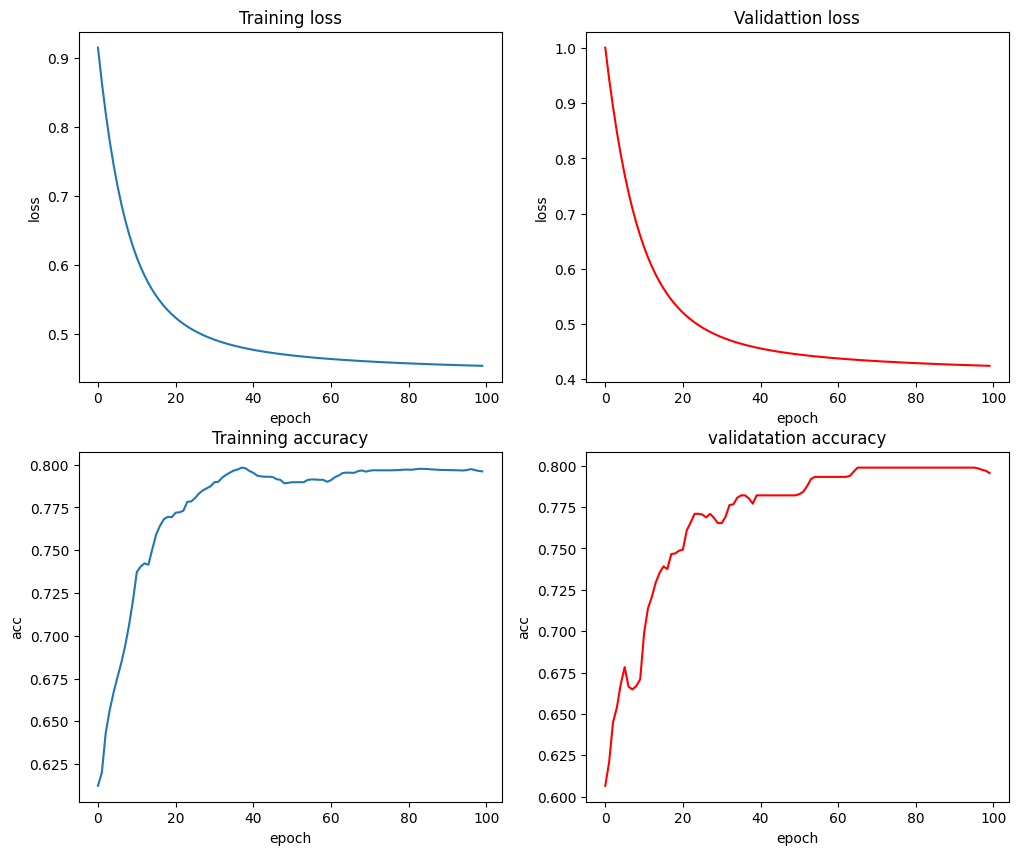

In [30]:
fig, ax = plt.subplots(2,2, figsize = (12,10))
ax[0,0].plot(train_losses)
ax[0,0].set_xlabel('epoch')
ax[0,0].set_ylabel('loss')
ax[0,0].set_title('Training loss')

ax[0,1].plot(val_losses, color = 'red')
ax[0,1].set_xlabel('epoch')
ax[0,1].set_ylabel('loss')
ax[0,1].set_title('Validattion loss')

ax[1,0].plot(train_accs)
ax[1,0].set_xlabel('epoch')
ax[1,0].set_ylabel('acc')
ax[1,0].set_title('Trainning accuracy')

ax[1,1].plot(val_accs, color = 'red')
ax[1,1].set_xlabel('epoch')
ax[1,1].set_ylabel('acc')
ax[1,1].set_title('validatation accuracy')

# exercise 2

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk import TweetTokenizer
from collections import defaultdict

In [38]:
# read data
data = pd.read_csv('sentiment_analysis.csv', index_col='id')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7920 entries, 1 to 7920
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   7920 non-null   int64 
 1   tweet   7920 non-null   object
dtypes: int64(1), object(1)
memory usage: 185.6+ KB


In [53]:

# preprocess data
def preprocess_data(text_data):
    text_data = re.sub(r'^RT[\s]+','',text_data)

    #Hyperlink removal
    text_data = re.sub(r'hppt?: \/\/.*[\r\n]*', '', text_data)

    # removle hagstag
    text_data = re.sub(r'#', '', text_data)

    # puntuation removal
    text_data = re.sub(r'[^\w\s]', '', text_data)

    # tokenization
    tokenizer = TweetTokenizer(
        preserve_case=False,
        strip_handles=True,
        reduce_len=True,
    )
    text_tokens = tokenizer.tokenize(text_data)
    return text_tokens


def get_freq(data):
    # Create a new dictionaty
    freqs = defaultdict(lambda: 0)
    for idx, row in data.iterrows():
        tweet = row['tweet']
        label = row['label']

        tokens = preprocess_data(tweet)
        for token in tokens:
            pair = (token, label)
            freqs[pair] = freqs[pair] + 1

    return freqs


def get_feature(data, freqs):
    tokens = preprocess_data(data)

    x = np.zeros(3)
    x[0] = 1

    for token in tokens:
        x[1] += freqs[(token,0)]
        x[2] += freqs[(token,1)]
    return x

In [59]:
x = []
y = []

freqs = get_freq(data)

for idx, row in data.iterrows():
    tweet = row['tweet']
    label = row['label']

    x.append(get_feature(tweet, freqs))
    y.append(label)

x = np.array(x)
y = np.array(y).reshape(-1,1)

In [62]:
val_size = 0.2
test_size = 0.125
random_state = 42
is_shuffle = True
x_train, x_val, y_train, y_val = train_test_split(x, y,  test_size= val_size,
                                                  random_state=random_state, shuffle=is_shuffle )
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size,  
                                                    random_state=random_state, shuffle=is_shuffle)

In [63]:
scaler = StandardScaler()
x_train_processed = scaler.fit_transform(x_train)
x_val_processed = scaler.transform(x_val)
x_test_processed = scaler.transform(x_test)

In [64]:
def add_bias_to_x(data):
    interpret = np.ones((data.shape[0],1))
    x_b =np.concatenate((interpret, data), axis = 1)
    return x_b

In [65]:
x_b_train_processed = add_bias_to_x(x_train_processed)
x_b_val_processed = add_bias_to_x(x_val_processed)
x_b_test_processed = add_bias_to_x(x_test_processed)

In [66]:
np.random.seed(42)
lr = 0.01
batch_size = 16
epoches = 100
theta = np.random.randn(x_b_train_processed.shape[1],1) 
train_losses = []
train_accs = []
val_losses = []
val_accs = []
theta_es = [theta]
n = len(x_b_train_processed)
for epoch in range(epoches):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []
    for i in range(0, x_b_train_processed.shape[0], batch_size):
        xi = x_b_train_processed[i:i+batch_size]
        yi = y_train[i:i+batch_size]

        zi, y_hat = predict(x_data=xi, theta=theta)
        loss = loss_funtion(y_hat, yi)
        grad = gradient(xi, y_hat, yi)
        theta = update_theta(theta, grad, lr)
        acc = com_accuracy(x_b_train_processed, y_train, theta)

        _,val_pred = predict(x_data = x_b_val_processed,theta=theta)
        val_loss = loss_funtion(val_pred,y_val)
        val_acc = com_accuracy(x_b_val_processed,y_val,theta)

        train_batch_losses.append(loss)
        train_batch_accs.append(acc)

        val_batch_losses.append(val_loss)
        val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses)/len(train_batch_losses)
    train_batch_acc = sum(train_batch_accs)/len(train_batch_accs)
    val_batch_loss = sum(val_batch_losses)/len(val_batch_losses)
    val_batch_acc = sum(val_batch_accs)/len(val_batch_accs)


    train_losses.append(train_batch_loss)
    train_accs.append(train_batch_acc)
    val_losses.append(val_batch_loss)
    val_accs.append(val_batch_acc)
    theta_es.append(theta)

            


Text(0.5, 1.0, 'validatation accuracy')

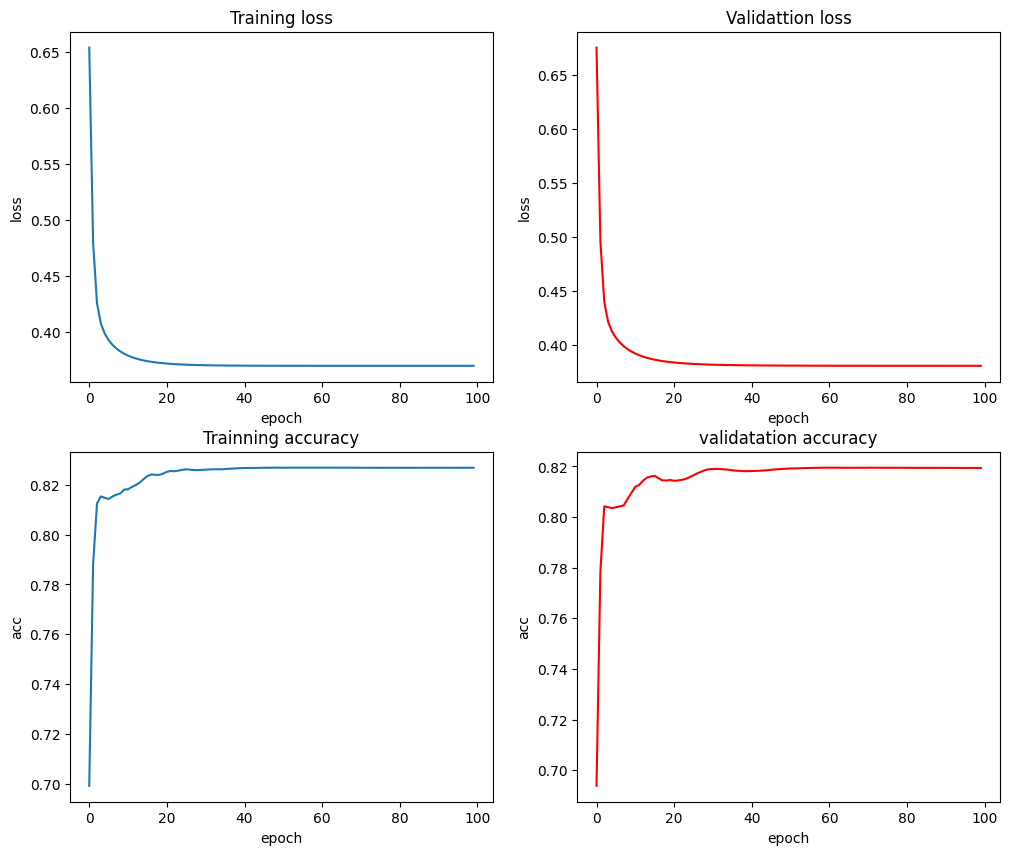

In [67]:
fig, ax = plt.subplots(2,2, figsize = (12,10))
ax[0,0].plot(train_losses)
ax[0,0].set_xlabel('epoch')
ax[0,0].set_ylabel('loss')
ax[0,0].set_title('Training loss')

ax[0,1].plot(val_losses, color = 'red')
ax[0,1].set_xlabel('epoch')
ax[0,1].set_ylabel('loss')
ax[0,1].set_title('Validattion loss')

ax[1,0].plot(train_accs)
ax[1,0].set_xlabel('epoch')
ax[1,0].set_ylabel('acc')
ax[1,0].set_title('Trainning accuracy')

ax[1,1].plot(val_accs, color = 'red')
ax[1,1].set_xlabel('epoch')
ax[1,1].set_ylabel('acc')
ax[1,1].set_title('validatation accuracy')

# Test

In [35]:
#read_data
df = pd.read_csv('titanic_modified_dataset.csv')
x = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].to_numpy().reshape(-1,1)
n = len(x)
for i in range(n//batch_size + 1):
        m_batch = batch_size
        if i == n//batch_size:
            m_batch = n - (n//batch_size)*batch_size
            if m_batch == 0:
                break
        xi = x[i*batch_size:(i*batch_size + m_batch),:]
        print(xi[:,0])


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
[17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32.]
[33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.]
[49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64.]
[65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80.]
[81. 82. 83. 84. 85. 86. 87. 88. 89. 90. 91. 92. 93. 94. 95. 96.]
[ 97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112.]
[113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128.]
[129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142.
 143. 144.]
[145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158.
 159. 160.]
[161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174.
 175. 176.]
[177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190.
 191. 192.]
[193. 194. 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206.
 207. 208.]
[209. 210. 211. 212. 21

In [68]:
x = [[22.3, -1.5, 1.1, 1]]
theta = [0.1, -0.15, 0.3, -0.2]
a = predict(x, theta)
a


(array([2.585]), array([0.92988994]))

In [71]:
y = np.array([1,0,0,1])
y_hat = np.array([0.8, 0.75, 0.3, 0.95])
co_loss = loss_funtion(y_hat=y_hat, y=y)
co_loss

np.float64(0.5043515376900958)

In [74]:
x = np.array([[1,2], [2,1], [1,1], [2,2]])
y_true = np.array([0, 1, 0, 1])
y_pred = np.array([0.25, 0.75, 0.4, 0.8])
grad = gradient(x, y_pred, y_true)
grad

array([-0.0625,  0.0625])

In [76]:
x = np.array([[1,3], [2,1], [3,2], [1,2]])
y_true = np.array([1, 0, 1, 1])
y_pred = np.array([0.7, 0.4, 0.6, 0.85])
grad = gradient(x, y_pred, y_true)
grad

array([-0.2125, -0.4   ])